In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import json
import matplotlib.cm as cm
from geopy.distance import geodesic

In [2]:
# Extraemos la información de el archivo.json
#archino_nombre = "serviciosg.json"
archino_nombre = "serviciosp.json"

try:
    with open(archino_nombre) as archivo:
        servicios = json.load(archivo)
        print("Archivo cargado correctamente.")
except FileNotFoundError:
    print("El archivo no existe.")
    servicios = []
except json.JSONDecodeError:
    print("Error al decodificar el archivo JSON.")
    servicios = []


Archivo cargado correctamente.


In [3]:
# Creamos nuestro grafo
grafo = nx.Graph()
for servicio in servicios:
    grafo.add_node(
        servicio['id'],
        tipo=servicio['tipo'],
        tiempo=servicio['tiempo'],
        ubicacion=servicio['ubicacion'],
        color=servicio['color'],
        bloqueado=servicio['bloqueado'],
        flotilla=servicio['flotilla']
    )


In [4]:
# Vamos a obtener la ubicación de los servicios
ubicaciones = nx.get_node_attributes(grafo, 'ubicacion')
nodos = list(grafo.nodes())
ubicaciones_array = np.array([ubicaciones[nodo] for nodo in nodos])

# Pequeño validador para ver si todos los nodos tienen ubicación
if None in ubicaciones_array:
    print("Algunos nodos no tienen ubicación.")


In [5]:
# Vamos a trabajar con k-nearest neighbors utilizando distancias de Geopy
k = 5  # Número de vecinos

# Crear una matriz de distancias usando geodesic
n = len(ubicaciones_array)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:  # Evitamos calcular la distancia de un nodo consigo mismo
            dist_matrix[i, j] = geodesic(ubicaciones_array[i], ubicaciones_array[j]).kilometers

# Usar la matriz predefinida con NearestNeighbors
neigh = NearestNeighbors(n_neighbors=k + 1, metric='precomputed')  # +1 porque incluye el nodo mismo
neigh.fit(dist_matrix)
distances, indices = neigh.kneighbors(dist_matrix)

# Agregar las distancias como aristas en el grafo
for idx, nodo in enumerate(nodos):
    for neighbor_idx in indices[idx][1:]:  # Saltar la distancia al mismo nodo (posición 0)
        neighbor_node = nodos[neighbor_idx]
        distancia_calculada = distances[idx][list(indices[idx]).index(neighbor_idx)]
        grafo.add_edge(
            nodo,
            neighbor_node,
            peso=distancia_calculada  # Distancia geográfica en kilómetros
        )


In [6]:
# Vamos a probar con K-Means
n_clusters = 6

# K-Means requiere datos en un espacio cartesiano o euclidiano.
# Aquí convertimos las coordenadas geográficas a radianes para mayor precisión.
ubicaciones_rad = np.radians(ubicaciones_array)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ubicaciones_rad)
labels = kmeans.labels_


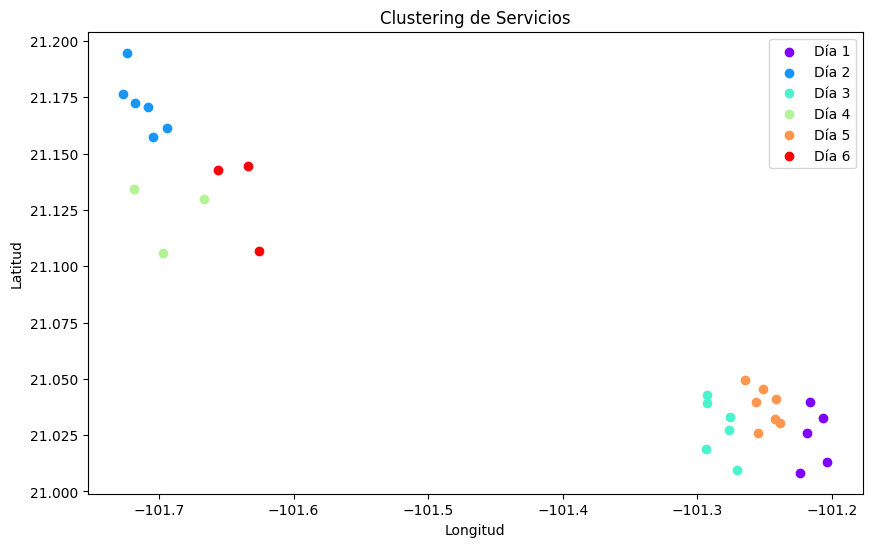

In [7]:
# Ahora vamos a visualizar los resultados
for idx, nodo in enumerate(nodos):
    grafo.nodes[nodo]['cluster'] = labels[idx]

colores = cm.rainbow(np.linspace(0, 1, n_clusters))

# Gráfico de clustering
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = ubicaciones_array[labels == i]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], color=colores[i], label=f'Día {i+1}')
plt.legend()
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clustering de Servicios')
plt.show()


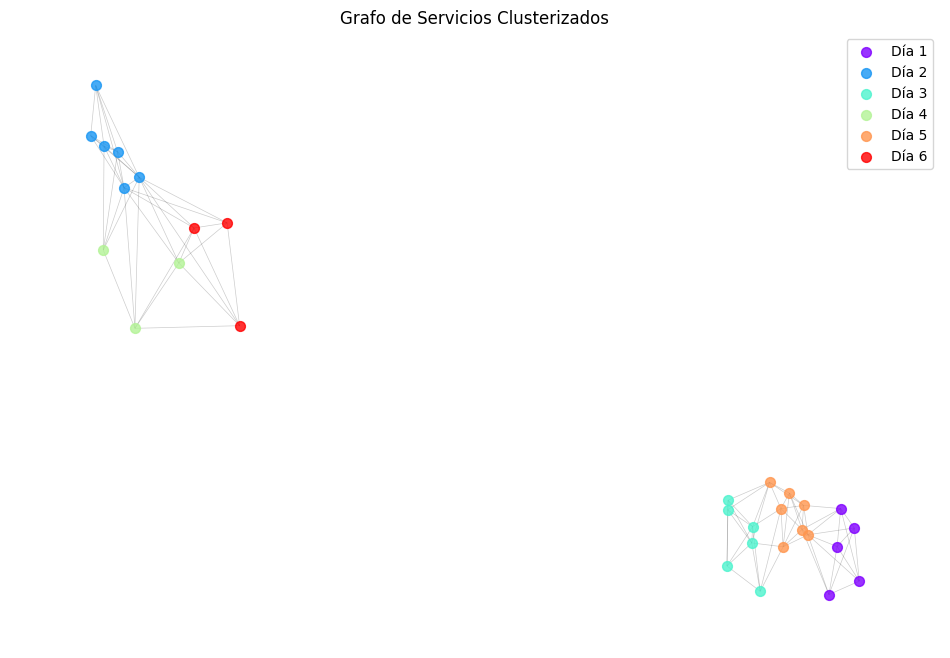

In [8]:
# Visualización del grafo con clústeres
plt.figure(figsize=(12, 8))
posiciones = {nodo: (ubicaciones[nodo][1], ubicaciones[nodo][0]) for nodo in nodos}

for i in range(n_clusters):
    cluster_nodos = [nodo for nodo in nodos if grafo.nodes[nodo]['cluster'] == i]
    nx.draw_networkx_nodes(
        grafo,
        pos=posiciones,
        nodelist=cluster_nodos,
        node_color=[colores[i]],
        node_size=50,
        alpha=0.8,
        label=f'Día {i+1}'
    )

nx.draw_networkx_edges(grafo, pos=posiciones, alpha=0.2, width=0.5)

plt.legend(scatterpoints=1)
plt.title('Grafo de Servicios Clusterizados')
plt.axis('off')
plt.show()
